In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import sklearn.preprocessing as preprocessing

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pylab as plt
from keras.utils import np_utils 
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
import itertools


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"
source_path = "I:\\Honours-Project\\data\\sorted\\agg\\cropped\\"
csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [3]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

In [4]:
df = df[df['name'].str.contains("_flipped")]

In [5]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(df.groupby('flow_rate').size())

flow_rate
1800    58
3600    58
7200    58
dtype: int64


In [17]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,log_volume
116,122_flipped,2017.11.22,2,37.40 s.tifheightmap.mat,4.319409,2349,5376.535741,0.912341,1,0.406753,2.288862,[[2.34900000e+03 8.65810000e+04 3.99522700e+06...,-0.840337,244.350288,[[ 292.62940001 -224.93021006]\r\n [-224.93021...,2,1,8.589800
143,197_flipped,2017.11.23,2,36.00 s.tifheightmap.mat,19.083013,3122,29222.399419,0.957761,1,0.315992,9.360154,[[3.12200000e+03 1.79358000e+05 1.46038540e+07...,1.295739,306.835570,[[ 222.11597891 354.20156308]\r\n [ 354.20156...,0,2,10.282691
64,13_flipped,2017.11.09,1,chip3_04heightmap.mat,8.268838,1136,4832.504854,0.896216,1,0.780220,4.253966,[[1.13600000e+03 3.06810000e+04 1.06870300e+06...,-1.450708,149.597980,[[ 44.53901756 -20.42403231]\r\n [-20.42403231...,0,1,8.483120
55,0_flipped,2017.11.09,0,chip2_02heightmap.mat,58.496427,4489,152983.389556,0.866207,0,0.673316,34.079615,[[4.48900000e+03 2.35521000e+05 1.56682350e+07...,-1.309976,365.220346,[[ 232.59219643 -145.14005797]\r\n [-145.14005...,0,1,11.938085
144,52_flipped,2017.11.17,2,1.90 s.tifheightmap.mat,7.665951,1655,6732.873700,0.948445,1,0.757055,3.921301,[[1.71700000e+03 7.67380000e+04 4.19110800e+06...,-1.495170,197.396970,[[ 47.06751865 -30.20988715]\r\n [-30.20988715...,2,1,8.814757


In [7]:
nb_classes = 3

In [8]:
x = []
y = []

df['log_volume'] = df['volume'].apply(np.log)

mat = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical features
mat = mat.drop(columns=['cluster'])

X = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

y = df["flow_rate"].values

y[y == 1800] = 0
y[y == 3600] = 1
y[y == 7200] = 2

one_hot = np_utils.to_categorical(df["flow_rate"].values, nb_classes)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, one_hot, test_size=36, stratify=y)

We add the flip of each image to the split dataset. Therefore, there is no information transfer between test and training sets. To Do.

In [54]:
num_samples = X_train.shape[0]
num_features = X_train.shape[1]

num_classes = y_train.shape[1]
#Orientation column
oc = 5

print(X_train.shape)

for i in range(X_train.shape[0]):
    sample = X_train[i]
    flipped_sample = sample.copy()
    flipped_sample[oc] = 0 - sample[oc]
    flipped_sample = flipped_sample.reshape((1,num_features))
    X_train = np.concatenate((X_train, flipped_sample))
    y_train = np.concatenate((y_train, y_train[i].copy().reshape(1, num_classes)))
    
for i in range(X_test.shape[0]):
    sample = X_test[i]
    flipped_sample = sample.copy()
    flipped_sample[oc] = 0 - sample[oc]
    flipped_sample = flipped_sample.reshape((1,num_features))
    X_test = np.concatenate((X_test, flipped_sample))
    y_test = np.concatenate((y_test, y_test[i].copy().reshape(1, num_classes)))

(138, 11)


## sklearn Gradiant Boosted Forest

In [55]:
rfc = RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.1, 
                       min_samples_leaf=4, min_samples_split=9, n_estimators=100)

In [56]:
n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

i = 0

for train, test in skf.split(X,y):
    print("Running Fold", i+1, "/", n_folds)
    i+=1
    
    std = np.std(X[train],0)
    mean = np.mean(X[train],0)
            
    X_train = (X[train] - mean)/std
    X_test = (X[test] - mean)/std 
        
    y_train = y[train]
            
    model = None # Clearing the NN.
    
    # Hyperparameters found by TPOT
    model = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, 
                                       max_features=0.1, min_samples_leaf=8, min_samples_split=12, 
                                       n_estimators=100, subsample=0.9500000000000001)

    # Hyperparameters copied from Random Forest
    # model = GradientBoostingClassifier(max_features=0.1, 
                # min_samples_leaf=4, min_samples_split=9, n_estimators=100, verbose=1)
    
    model.fit(X_train, y_train)
            
    # Predict the values from the validation dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    # Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = y[test]
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred)
    
    print("Accuracy: ", sum(Y_pred == Y_true)/len(Y_true))

Running Fold 1 / 10
Accuracy:  0.3333333333333333
Running Fold 2 / 10
Accuracy:  0.3333333333333333
Running Fold 3 / 10
Accuracy:  0.2222222222222222
Running Fold 4 / 10
Accuracy:  0.4444444444444444
Running Fold 5 / 10
Accuracy:  0.4444444444444444
Running Fold 6 / 10
Accuracy:  0.2777777777777778
Running Fold 7 / 10
Accuracy:  0.2777777777777778
Running Fold 8 / 10
Accuracy:  0.4444444444444444
Running Fold 9 / 10
Accuracy:  0.26666666666666666
Running Fold 10 / 10
Accuracy:  0.4666666666666667


In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

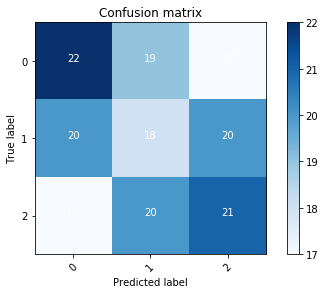

In [58]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 